In [34]:
from math import floor
import pandas as pd
import os
from binance.client import Client
import datetime, time
import numpy as np

# howLong = 2 * 365
#     # Calculate the timestamps for the binance api function
# untilThisDate = datetime.datetime.now()
# sinceThisDate = untilThisDate - datetime.timedelta(days = howLong)
# client = Client(api_key, api_secret)
#     # Execute the query from binance - timestamps must be converted to strings !
# candle = client.get_historical_klines("BNBBTC", Client.KLINE_INTERVAL_1MINUTE, str(sinceThisDate), str(untilThisDate))

#     # Create a dataframe to label all the columns returned by binance so we work with them later.
# df = pd.DataFrame(candle, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'])
#     # as timestamp is returned in ms, let us convert this back to proper timestamps.
# #self.df.dateTime = pd.to_datetime(self.df.dateTime, unit='ms').dt.strftime(Constants.DateTimeFormat)
# df = df.set_index('dateTime', inplace=True)

#     # Get rid of columns we do not need
# df = df.drop(['closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol','takerBuyQuoteVol', 'ignore'], axis=1)

df = pd.read_csv("LTCUSDT-5m-2021-11.csv")
df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore']

df = df.set_index('open_time')



df = df.drop(['close_time', 'ignore'], axis=1)

df



,open,high,low,close,volume,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
open_time,,,,,,,,,
1635725100000,191.43,192.02,191.37,192.02,2793.815,5.355669e+05,1297,1385.168,2.655765e+05
1635725400000,192.02,193.32,191.93,193.01,10168.770,1.960809e+06,3851,5928.260,1.143253e+06
1635725700000,192.98,193.76,192.92,193.62,8579.165,1.659771e+06,2904,3799.094,7.349429e+05
1635726000000,193.60,193.72,193.02,193.37,4839.350,9.358926e+05,1951,2065.522,3.995075e+05
1635726300000,193.36,193.69,193.31,193.39,4937.114,9.553264e+05,1758,2668.693,5.164217e+05
...,...,...,...,...,...,...,...,...,...
1638315300000,208.33,208.91,208.15,208.77,4036.863,8.414236e+05,1373,1840.337,3.837659e+05
1638315600000,208.78,209.18,208.77,209.00,2471.871,5.165802e+05,1203,1103.075,2.305155e+05
1638315900000,209.00,209.19,207.60,207.73,5946.212,1.237775e+06,2159,1900.718,3.957291e+05


### Calculating MACD

In [35]:
# Get the 26-day EMA of the closing price
k = df['close'].ewm(span=12, adjust=False, min_periods=12).mean()
# Get the 12-day EMA of the closing price
d = df['close'].ewm(span=26, adjust=False, min_periods=26).mean()
# Subtract the 26-day EMA from the 12-Day EMA to get the MACD
macd = k - d
# Get the 9-Day EMA of the MACD for the Trigger line
macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()
# Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
macd_h = macd - macd_s
# Add all of our new values for the MACD to the dataframe
df['macd'] = df.index.map(macd)
df['macd_h'] = df.index.map(macd_h)
df['macd_s'] = df.index.map(macd_s)

#df.index = pd.DatetimeIndex(df['open_time'].to_period('M'))

df.index = pd.to_datetime(df.index, unit='ms')
df.index = pd.DatetimeIndex(df.index).to_period('M')
df_test = df[floor(-0.2*len(df)): -1]
df_train = df[0 : len(df_test)]

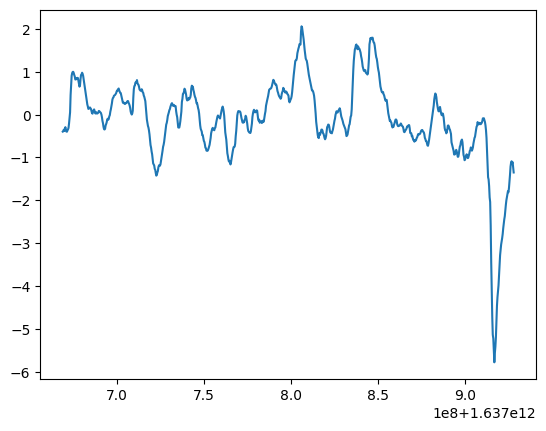

In [30]:
import matplotlib.pyplot as plt

plt.plot(df["macd"][floor(0.75*len(df)):floor(0.85 * len(df))])
plt.show()

### Weak learner

In [9]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn import utils

features = df.copy()
target = features['macd'].dropna()
features = features[features["macd"].notna()].drop(['macd', 'macd_h', 'macd_s'], axis=1)

lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(target)
y_transformed

dtree = DecisionTreeClassifier()
dtree = dtree.fit(features, y_transformed)

# tree.plot_tree(dtree, feature_names=features.columns) 

In [41]:
# ARIMA example
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from random import random
# contrived dataset
data = df_train['macd'].dropna()[-100:]
# fit model
model = ARIMA(data, order=(2, 3, 1))
model_fit = model.fit()
# make prediction
# yhat = model_fit.predict(len(data), len(data), type='levels')
# print(yhat)

prediction = model_fit.forecast(26)
#df_test[:26]
mean_squared_error(prediction, df_test["macd"][0:26])

/home/olegsandrr/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1.026352072989118

In [ ]:
prediction

In [ ]:
#RNN - наверное слишком сильно для слабого ученика

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

def get_train_test(url, split_percent=0.8):
    df = pd.read_csv(url, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data
 
# Prepare the input X and target Y
def get_XY(dat, time_steps):
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y
 
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
 
def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    
 
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
 
sunspots_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
time_steps = 12
train_data, test_data, data = get_train_test(sunspots_url)
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)
 
# Create model and train
model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)
 
# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
 
# Print error
print_error(trainY, testY, train_predict, test_predict)
 
#Plot result
plot_result(trainY, testY, train_predict, test_predict)

# Bagging
В случае временных рядов берется разное количество обучающих примеров у слабых учеников

In [46]:
num_of_models = 10
prediction_size = 26
errors = np.empty(num_of_models)
predictions = np.empty((num_of_models, prediction_size))
#models = [num_of_models]
for i in range(1, num_of_models):
    data = df_train['macd'].dropna()[-100 * i:]
    # fit model
    models = ARIMA(data, order=(2, 3, 1))
    model_fit = models.fit()
    # make prediction

    predictions[i - 1] = model_fit.forecast(prediction_size)
    print(str(mean_squared_error(predictions[i - 1], df_test["macd"][0:26])) + '\n')

ensemble_prediction = predictions.mean(1)
print('ensemble prediction: ' + str(mean_squared_error(ensemble_prediction, df_test["macd"][0:26])))

/home/olegsandrr/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/olegsandrr/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.9524393141860104

0.8844978619574858



/home/olegsandrr/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.9790410245731456

1.0099519855972912



/home/olegsandrr/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/olegsandrr/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1.0790803729577105

1.0304809209385934



/home/olegsandrr/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1.0780851257811703

1.0746190093224124

1.0793689577284884



/home/olegsandrr/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ValueError: Found input variables with inconsistent numbers of samples: [10, 26]

In [ ]:
# params = {'num_leaves': 30,
#           'n_estimators': 400,
#           'max_depth': 8,
#           'min_child_samples': 200,
#           'learning_rate': 0.1,
#           'subsample': 0.50,
#           'colsample_bytree': 0.75
#          }


# model = lgb.LGBMRegressor(**params)
# model = model.fit(x_train.drop(columns=['timestamp']), y_train)

# Real-time predictions

Цикл, где я предсказываю некое количество шагов, потом двигаюсь на один период вперед и добавляю его к модели?